## Calc de gradient vector for a cavity. 

# Ahora voy a probar con un desplazamiento negativo y otro positivo, p/ calcular la derivada con estos 2 puntos y así obtener la derivada p/ el punto central (la struct average)

In [1]:
using DataFrames
using Gadfly
using Cairo
using MIToS.PDB
set_default_plot_size(28cm, 10cm)

    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /home/german/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.DataArray, AbstractArray) at /home/german/.julia/v0.4/DataArrays/src/operators.jl:276.
To fix, define 
    +(DataArrays.DataArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury)
before the new definition.
    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /home/german/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.AbstractDataArray, AbstractArray) at /home/german/.julia/v0.4/DataArrays/src/operators.jl:300.
To fix, define 
    +(DataArrays.AbstractDataArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury)
before the new definition.


In [2]:
function meta_var(s::AbstractString,v::Any)
         s=symbol(s) 
         @eval (($s) = ($v))
end

meta_var (generic function with 1 method)

In [3]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [71]:
function read_ptraj_modes(file, modes_elements, norma::Bool=true)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)

    nmodes = modes_text[1, 5]
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 2 methods)

In [5]:
function displaceAA(mod_pdb, vector1, multiplier)
  # Preparo variables
   pdb = copy(mod_pdb)
   struct_xyz = coordinatesmatrix(pdb)
   new_struct_xyz = copy(struct_xyz)
   natom = Array{Int64}(1)
    vector = Array{Float64}(1, 3)
   aa = length(pdb)
   # Determino el nro de atomos de c/ aminoácido
   for i=1:aa
       push!(natom, length(pdb[i]))
   end  
   shift!(natom)
   temp1 = Array{Int64}(natom[1],3)

   # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    for i=1:3:length(vector1)
        if i== 1
            vector = reshape(vector1[i:i+2], 1, 3)
            continue
        end
        vector = vcat(vector, reshape(vector1[i:i+2], 1, 3))
    end

   for i=1:aa
       if i == 1         
           temp1 = repmat(vector[i, :], natom[i], 1)
           continue
       end  
       temp2 = repmat(vector[i, :], natom[i], 1)
       temp1 = vcat(temp1, temp2)
   end  
   sum_mat = temp1

   # Listo, ahora puedo mover el pdb
   new_struct_xyz  = struct_xyz + sum_mat .* multiplier
   pdb = change_coordinates(pdb, new_struct_xyz);
   return pdb
end

displaceAA (generic function with 1 method)

In [6]:
function WeightedHist(in_vec, in_bins, in_weight)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        temp_bool = (in_vec .>= in_bins[i]) & (in_vec .< in_bins[i+1])
        out_counts[i] = sum(in_weight[temp_bool])
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    return out_counts, out_middle
end

WeightedHist (generic function with 1 method)

# Gradiente en base de modos de PCA

### Preparo variables y leo archivos de pdb y modos.

In [7]:
# Preparo variables
natom_res = Array{Int64}(1);
# Leo el pdb
prt_name = "1hvr_apo"
pdb_filename = string("/home/german/labo/16/exs/cavities/bu/avg_", prt_name, ".pdb")
hvr_apo_pdb = read(pdb_filename, PDBFile, group="ATOM");

# Obtengo el número de átomos de c/ residuo
for i=1:length(hvr_apo_pdb)
    push!(natom_res, length(hvr_apo_pdb[i]))
end
shift!(natom_res)

# Obtengo el nro de aa's
aa = length(hvr_apo_pdb)
aa3 = aa * 3
modo_sum = Array{Float64}(aa, 3);

# Arrays p/ guardar volumenes de pockets
vol_pocket_mtn = Array{Float64}(aa3-6);
vol_ndd = Array{Float64, 2}(0, 2);
factorr = Array{Float64}(aa3-6);

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_prt, evals_prt = read_ptraj_modes("/home/german/labo/16/exs/run/1hvr_apo/pca/modes_1hvr_apo", aa3);

# Template p/ pdbs de salida
files_template = "/home/german/labo/16/exs/cavities/1hvr_apo/"
# Archivos de config de ANA
conf_prt_whole = "/home/german/labo/16/exs/cavities/bu/1hvr_apo.cfg"

"/home/german/labo/16/exs/cavities/bu/1hvr_apo.cfg"

### Desplazo la estructura original a lo largo de cada modo. Los modos son normalizados y luego multiplicados por -2 y 2; y así obtener distintos desplazamientos. Creando así 2 sets, c/u de 339 estructuras desplazadas (1 por c/ modo)

In [8]:
constant = 3
# Ahora tengo q mover la estructura a lo largo de los modos normales, pero esto requiere rearreglar
# los modos p/ q tengan el mismo formato q las coordenadas de los atomos
for magnitude in [-2 2]
    if magnitude >= 0
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    temp1_modo_sum = Array{Float64}(natom_res[1], 3)
    for j=1:aa3-6
        for i=1:aa
            modo_sum[i, 1] = modes_prt[i*3-2, j]
            modo_sum[i, 2] = modes_prt[i*3-1, j]
            modo_sum[i, 3] = modes_prt[i*3, j]
        end
# Ya tengo el modo en el formato adecuado, pero estos son p/ mover Calphas. Ahora tengo q
# repetir sus filas p/ poder mover todos los atomos de c/ aminoacido.
        for i=1:aa
            if i == 1
                temp1_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
                continue
            end
            temp2_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
            temp1_modo_sum = vcat(temp1_modo_sum, temp2_modo_sum)
        end
modo_sum = copy(temp1_modo_sum)
# Ajusto el desplazamiento q voy a hacer
        factorr[j] = magnitude * constant * 1/evals_prt[j]
# Modifico las coordenadas
        hvr_apo_atom_xyz = coordinatesmatrix(hvr_apo_pdb)
        new_hvr_apo_atom_xyz = hvr_apo_atom_xyz + modo_sum .* factorr[j];
# Obtengo un nuevo frame con las coordenadas modificadas
        new_hvr_apo_pdb = change_coordinates(hvr_apo_pdb, new_hvr_apo_atom_xyz)
# Escribo el nuevo .pdb
        pdb_hvr_apo = string(files_template, displacement, "/", "mod", j, "_", displacement, "_hvr_apo.pdb")
        write(pdb_hvr_apo, new_hvr_apo_pdb, PDBFile)
    end
end

### Ahora calculo los volumenes de los huecos corto, portal, largo y whole p/ los 2 sets de 345 estructuras desplazadas. Y así junto 2 sets (1 por c/ magnitud de desplazamiento) de 4 vectores (1 por c/ hueco) de 345 elementos c/u (1 elemento -> 1 volumen de 1 hueco de 1 estructura desplazada en alguna de sus coordenadas x,y,z)
### Luego le resto los volumenes originales de los huecos corto, portal, largo y whole a c/u de los elementos de los 8 vectores y así obtengo 2 sets de 4 vectores gradiente en base de coordenadas cartesianas.

In [9]:
# Obtengo los vectores de volúmenes p/ los 4 huecos con desplazamientos negativos y positivos
for magnitude in [-2; 2]
    if magnitude >= 0
        magnitude_ = magnitude
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    # Preparo variables
    ndd_input_filename = string(files_template, displacement, "/inndd_", prt_name, "_", displacement)
    ndd_output_filename = string(files_template, displacement, "/outndd_", prt_name, "_", displacement)
    
    # WHOLE
    global vol_ndd = symbol("vol_ndd_whole_", displacement)
    global gdte_ndd = symbol("gdte_ndd_whole_", displacement)  
    # Calculo el pocket        
    run(`ANA $pdb_filename -c $conf_prt_whole -I $ndd_input_filename -O $ndd_output_filename`);
    # Leo
    ndd_output = readdlm(ndd_output_filename, header=true)[1][:, 2]
    @eval ($vol_ndd = $ndd_output)
    @eval ($gdte_ndd = $ndd_output .- parse(Float64, readall(`ANA $pdb_filename -c $conf_prt_whole`)))
end

Chemfiles warning: Unknown PDB record: TER    1562      PHE    99 


1085.38


Chemfiles warning: Unknown PDB record: TER    1562      PHE    99 
Chemfiles warning: Unknown PDB record: TER    1562      PHE    99 


1085.38


Chemfiles warning: Unknown PDB record: TER    1562      PHE    99 


In [10]:
# Ahora obtengo el gradiente entre los desplazamientos negativo y positivo.
gdte_whole = (vol_ndd_whole_d2 - vol_ndd_whole_d_2) .* evals_prt;

# Los vectores tienen el (delta)volumen. Puedo elegir normalizarlos o dividirlos por el desplazamiento
# o lo q sea. Los normalizo
gdte_whole = gdte_whole / norm(gdte_whole);

## Grafico los vectores. El eje 'x' es el nro de elemento y el 'y' el valor del elemento.

### Canal whole

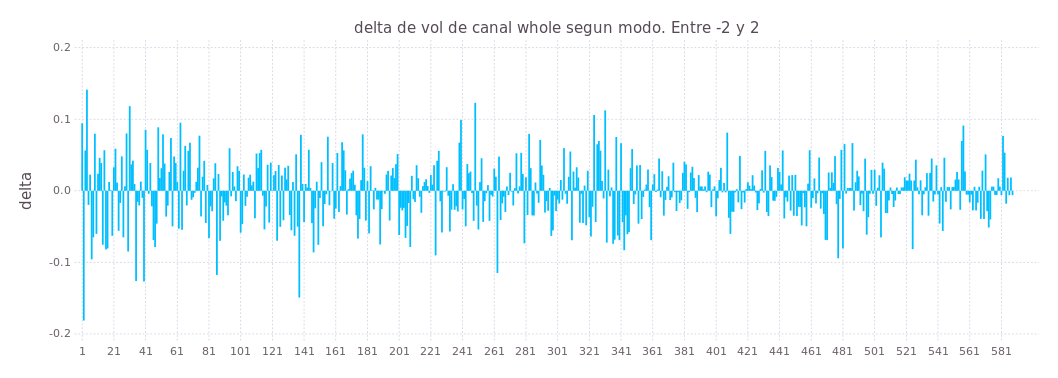

In [11]:
df_gdte_whole = DataFrame(delta = gdte_whole)
pdf_gdte_whole = plot(df_gdte_whole,
y="delta",
Geom.bar(position=:dodge),
Guide.Title("delta de vol de canal whole segun modo. Entre -2 y 2"),
Coord.Cartesian(xmin=1, xmax=600),
Guide.xticks(ticks = collect(1:20:600), orientation=:horizontal))

### Guardo los gráficos en 1 pdf

In [12]:
magnitude = 2
displacement = string("dd", magnitude)
out_filename_pdf_gdte_whole = string("/home/german/labo/16/exs/rtdos_log/", displacement,"_whole_1hvr_apo.pdf")
# Guardo los plots
draw(PDF(out_filename_pdf_gdte_whole, 20cm, 10cm), pdf_gdte_whole)

### Guardo los vectores

In [13]:
magnitude = 2
displacement = string("dd", magnitude)
out_filename_gdte_whole = string("/home/german/labo/16/exs/rtdos_log/", displacement,"_NDD_whole_1hvr_apo")
writetable(out_filename_gdte_whole, df_gdte_whole)

### Ahora obtengo los gradientes en bases cartesianas, p/ distinguir a los aminoácidos q más actúan

In [14]:
cart_ndd_whole_dd2 = modes_prt * gdte_whole
df_cart_ndd_whole_dd2 = DataFrame(delta = tognm(cart_ndd_whole_dd2));

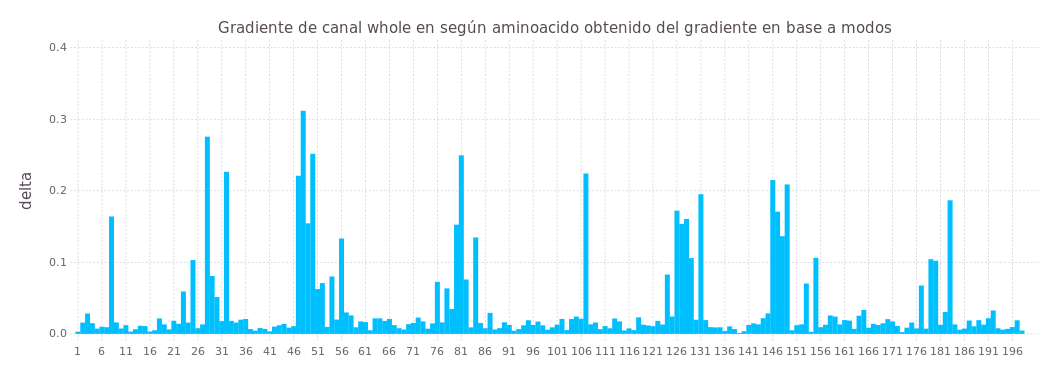

In [15]:
pdf_gdte_whole = plot(df_cart_ndd_whole_dd2,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("Gradiente de canal whole en según aminoacido obtenido del gradiente en base a modos"),
Coord.Cartesian(xmin=1, xmax=200),
Guide.xticks(ticks = collect(1:5:200), orientation=:horizontal))

## Continuación de gradientes en base a modos de PCA
## 4_ delta de vol de canal segun colectividad de modos (histograma)
## 5_ idem, pero recortando los vectores p/ quedarme con los elementos q se corresponden a aminoácidos de las paredes.
## 6_  gráfico de los modos q más varían al hueco

### Antes de calcular colectividad le pongo 0.00001 a los elementos nulos. Así no me da NaN

In [16]:
modes_prt_1 = Array{Float64}(aa3, aa3-6);
modes_prt__1 = Array{Float64}(aa3, aa3-6);

# Arreglo el pbma de 0
for i=1:size(modes_prt)[1]
    for j=1:size(modes_prt)[2]
        if modes_prt[i, j] == 0
            modes_prt_1[i, j] = 0.00001
        else
            modes_prt_1[i, j] = modes_prt[i, j]
        end
    end
end
# Arreglo el pbma de 0
for i=1:size(modes_prt)[1]
    for j=1:size(modes_prt)[2]
        if modes_prt[i, j] == 0
            modes_prt__1[i, j] = -0.00001
        else
            modes_prt__1[i, j] = modes_prt[i, j]
        end
    end
end

### Calculo colectividad de c/ modo usando a ecu (4) de SANEJOUAND; Conformational change of proteins arising from normal mode calculations

In [17]:
κ_1 = exp(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log(x.^2), modes_prt_1, 1), 1)) ./ size(modes_prt)[1]
κ_1 = reshape(κ_1, size(modes_prt)[2])

κ__1 = exp(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log(x.^2), modes_prt__1, 1), 1)) ./ size(modes_prt)[1]
κ__1 = reshape(κ__1, size(modes_prt)[2])

# kappa_1 y kappa__1 son iguales. Así q uso una de las 2
κ = κ_1;

### Plotteo

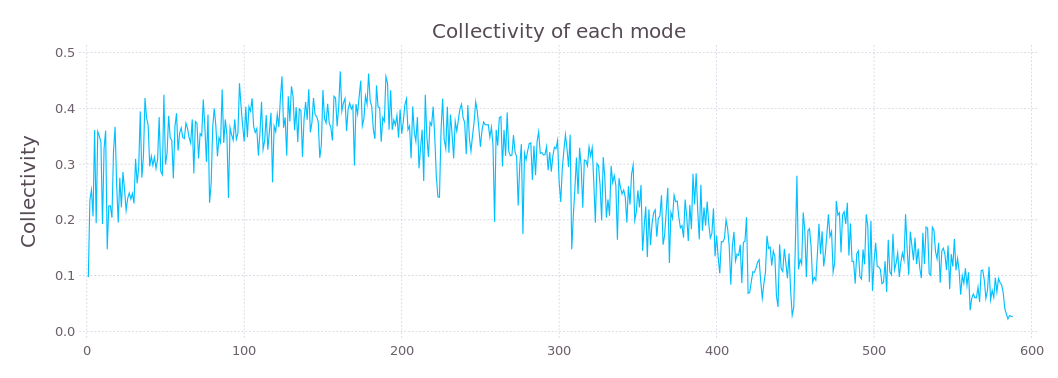

In [18]:
plot(DataFrame(Collectivity=κ), y="Collectivity", Geom.line, 
Guide.title("Collectivity of each mode"), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

## 5_ idem, pero recortando los vectores p/ quedarme con los elementos q se corresponden a aminoácidos de las paredes.

### Determino los aminoácidos de las paredes del hueco, estableciendo un mínimo en el valor de su elemento correspondiente en el vector gradiente. 0.1 suele ser un buen mínimo.

In [19]:
# Paso a cartesianas y luego a aminoácidos
aa_gdte_whole = tognm(modes_prt*gdte_whole)

# 2 plots p/ decidir a ojo
plot(DataFrame(delta=sort(aa_gdte_whole, rev=true)), Geom.line, y="delta",
Guide.xticks(ticks=collect(1:1:25)), Coord.cartesian(xmin=1, xmax=25))

plot(DataFrame(delta=aa_gdte_whole), Geom.bar, y="delta",
Guide.xticks(ticks=collect(1:10:110)), Coord.cartesian(xmin=1, xmax=110))

mask_gdte_whole = aa_gdte_whole .>= 0.1;
indices_gdte_whole = find(x-> x==true, mask_gdte_whole)
wall_whole_nres = length(indices_gdte_whole)
println(indices_gdte_whole)

# Tengo los indices de los aa's del hueco. Ahora tengo q pasarlos a índices de elementos de modos
modeind_gdte_whole = reshape(mapslices(x -> [x*3-2; x*3-1; x*3], transpose(indices_gdte_whole), 1),
    3*wall_whole_nres)
println("\n gradient vector wall residues indices:\n", modeind_gdte_whole)

# Subsetteo los modos p/ aislar los componentes de los aa's del hueco
modes_prt_1_whole = modes_prt_1[modeind_gdte_whole, :];
modes_prt_1_whole = mapslices(x -> x/norm(x), modes_prt_1_whole, 1);

[8,25,28,32,47,48,49,50,56,80,81,84,107,126,127,128,129,131,146,147,148,149,155,179,180,183]

 gradient vector wall residues indices:
[22,23,24,73,74,75,82,83,84,94,95,96,139,140,141,142,143,144,145,146,147,148,149,150,166,167,168,238,239,240,241,242,243,250,251,252,319,320,321,376,377,378,379,380,381,382,383,384,385,386,387,391,392,393,436,437,438,439,440,441,442,443,444,445,446,447,463,464,465,535,536,537,538,539,540,547,548,549]


### Calculo colectividad de c/ modo recortado, usando a ecu (4) de SANEJOUAND; Conformational change of proteins arising from normal mode calculations

In [88]:
# CANAL WHOLE
κ_whole = exp(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log(x.^2), modes_prt_1_whole, 1), 1)) ./ size(modes_prt_1_whole)[1]
κ_whole = reshape(κ_whole, size(modes_prt_1_whole)[2]);

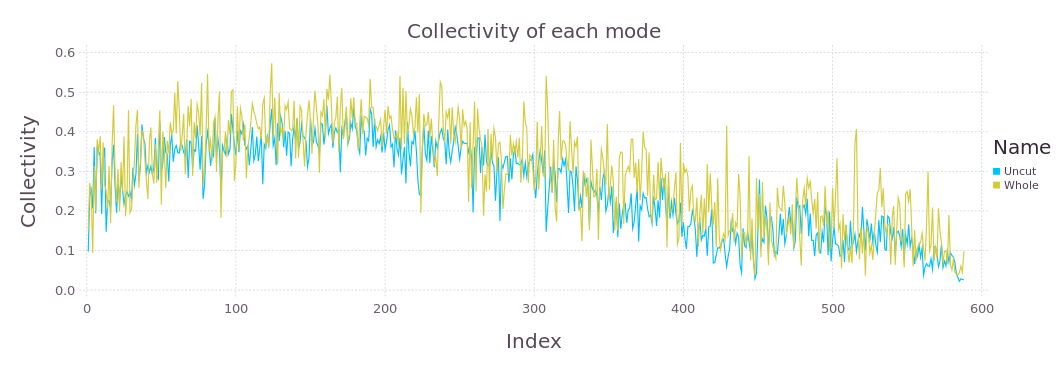

In [89]:
df_κ = DataFrame(Collectivity=[κ; κ_whole],
Name = [ repeat(["Uncut"], inner=[length(κ)]); repeat(["Whole"], inner=[length(κ_whole)]) ],
Index = repeat(collect(1:1:length(κ)), outer=[2]))

plot(df_κ, y="Collectivity", x="Index", color="Name", Geom.line,
Guide.title("Collectivity of each mode"),
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 15pt))

### Obtengo 3 histogramas: 
### No ponderado
### Ponderado por colectividad de modo
### Ponderado por colectividad de modo recortado p/ conservar aa's de paredes

In [22]:
# Los bins van de 0 al valor del elemento más alto del gradiente + 10% 
top = maximum(gdte_whole) * 1.1
bins_whole = collect(0:0.001:top)
bins_cut_whole = collect(0:0.01:top)
unos = repeat([1.0], inner=[length(κ)])

# Histograma no ponderado
gdte_whole_his, gdte_whole_bins = WeightedHist(abs(gdte_whole), bins_whole, unos);
df_gdte_whole_his = DataFrame(Count = gdte_whole_his, ∇Volume = gdte_whole_bins);

# Histograma por colectividad de modo 
gdte_whole_Whis, gdte_whole_Wbins = WeightedHist(abs(gdte_whole), bins_whole, κ);
df_gdte_whole_Whis = DataFrame(Count = gdte_whole_Whis, ∇Volume = gdte_whole_Wbins);

# Histograma por colectividad de modo recortado p/ conservar aa's de paredes
gdte_whole_Whis_cut, gdte_whole_bins_cut = WeightedHist(abs(gdte_whole), bins_whole, κ_whole)
df_gdte_whole_Whis_cut = DataFrame(Count = gdte_whole_Whis_cut, ∇Volume = gdte_whole_bins_cut);

### Plotteo

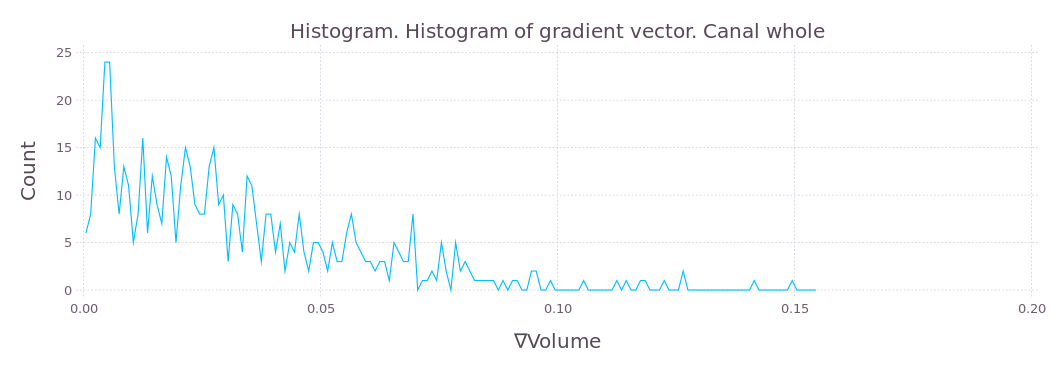

In [91]:
plot(df_gdte_whole_his, x="∇Volume", y="Count", Geom.line,
Guide.title("Histogram. Histogram of gradient vector. Canal whole"), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

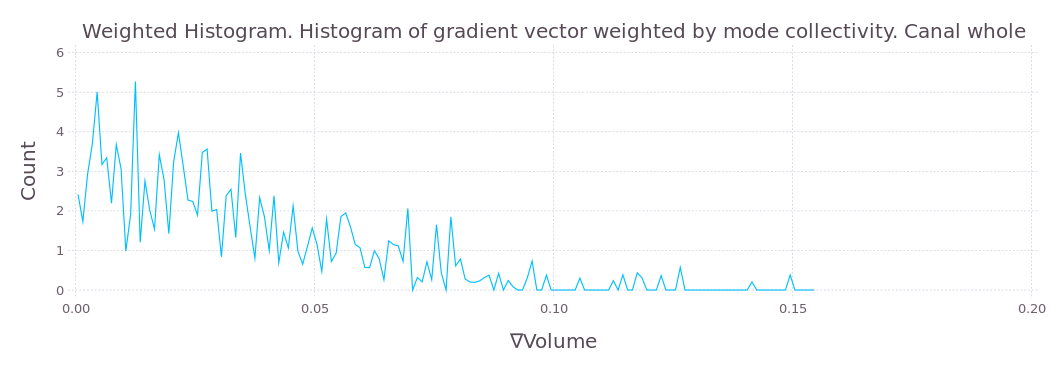

In [92]:
plot(df_gdte_whole_Whis, x="∇Volume", y="Count", Geom.line,
Guide.title("Weighted Histogram. Histogram of gradient vector weighted by mode collectivity. Canal whole"), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

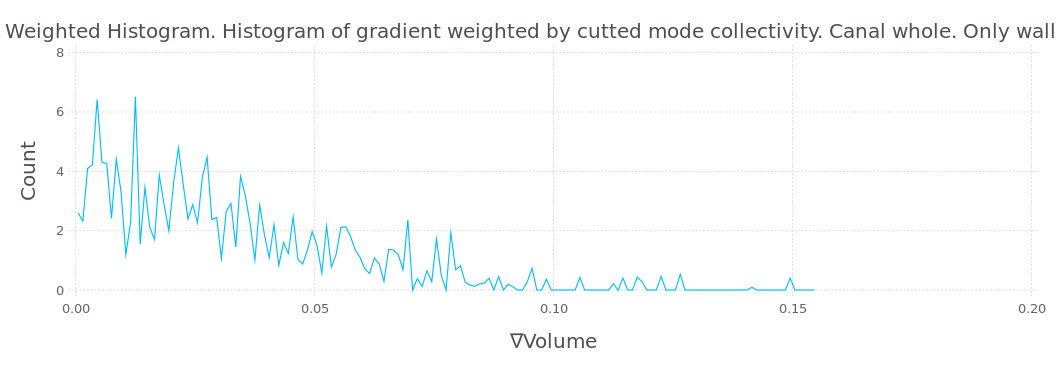

In [25]:
plot(df_gdte_whole_Whis_cut, x="∇Volume", y="Count", Geom.line,
Guide.title("Weighted Histogram. Histogram of gradient weighted by cutted mode collectivity. Canal whole. Only wall aa's"), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

## Los histogramas ponderados por colectividad completa y los ponderados por colectividad de aa's de la pared dan iguales. Si hago Histograma sin ponderar también da muy parecido.

In [98]:
vol_whole_apo_MD = readdlm("/home/german/labo/16/exs/cavities/1hvr_apo/vol_whole_1hvr_apo")
vol_whole_hol_MD = readdlm("/home/german/labo/16/exs/cavities/1hvr_hol/vol_whole_1hvr_hol")
cor(vol_whole_apo_MD[:, 2], vol_whole_hol_MD[:, 2])

0.006424924424856